### Import Libraries

In [128]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

import gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from collections import deque
import random

import matplotlib.dates as mdates
import seaborn as sns

### Download Data

In [129]:
# from finrl import config_tickers
# df = YahooDownloader(start_date = '2009-01-01',
#                            end_date = '2020-09-30',
#                            ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [130]:
import requests
import pandas as pd
import time

API_KEY = "Y9VLVP8TVKQBB5LK"  # Replace with your Alpha Vantage API Key

# FinRL requires "tic" instead of "ticker"
tck = [
    "AXP", "AMGN", "AAPL", "BA", "CAT", "CSCO", "CVX", "GS", "HD", "HON", 
    "IBM", "INTC", "JNJ", "KO", "JPM", "MCD", "MMM", "MRK", "MSFT", "NKE", 
    "PG", "TRV", "UNH", "CRM", "VZ", "V", "WBA", "WMT", "DIS", "DOW"
]

def fetch_alpha_vantage_data(symbol, start_date, end_date):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    
    if "Time Series (Daily)" not in data:
        print(f"Skipping {symbol}: No data returned.")
        return None
    
    df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")
    df.index = pd.to_datetime(df.index)  # Ensure index is in datetime format
    
    # Rename columns to match FinRL's expected format
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. adjusted close": "adj_close",
        "6. volume": "volume",
    })
    
    # Keep only necessary columns for FinRL
    df = df[["open", "high", "low", "close", "volume"]].astype(float)

    # Filter by date range
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]
    
    # Reset index and rename columns
    df = df.reset_index()
    df.rename(columns={"index": "date"}, inplace=True)
    
    # Add ticker column, rename it to "tic" to match FinRL
    df["tic"] = symbol
    
    # Add "day" column representing the day of the week
    df["day"] = df["date"].dt.day_name()

    return df

# Set date range
start_date = "2009-01-01"
end_date = "2020-09-30"

# Fetch data for all tickers
all_data = []
for ticker in DOW_30_TICKERS:
    print(f"Fetching data for {ticker}...")
    df = fetch_alpha_vantage_data(ticker, start_date, end_date)
    if df is not None:
        all_data.append(df)
    time.sleep(12)  # Respect Alpha Vantage API rate limits

# Combine all stock data
if all_data:
    final_df = pd.concat(all_data).sort_values(by=["date", "tic"]).reset_index(drop=True)
    
    # Save to CSV for future use
    final_df.to_csv("dow_30_alpha_vantage.csv", index=False)
    print("Data saved to dow_30_alpha_vantage.csv")

    # Display DataFrame (Jupyter Notebook)
    from IPython.display import display
    display(final_df.head())

else:
    print("No data retrieved.")


Fetching data for AAPL...
Fetching data for MSFT...
Fetching data for V...
Fetching data for JNJ...
Fetching data for WMT...
Fetching data for PG...
Fetching data for JPM...
Fetching data for UNH...
Fetching data for DIS...
Fetching data for NVDA...
Fetching data for HD...
Fetching data for MA...
Fetching data for VZ...
Fetching data for PYPL...
Fetching data for ADBE...
Fetching data for NFLX...
Fetching data for KO...
Fetching data for PFE...
Fetching data for MRK...
Fetching data for INTC...
Fetching data for PEP...
Fetching data for CSCO...
Fetching data for CRM...
Fetching data for T...
Fetching data for NKE...
Fetching data for MCD...
Fetching data for XOM...
Fetching data for IBM...
Fetching data for CAT...
Fetching data for BA...
Data saved to dow_30_alpha_vantage.csv


date     open   high    low  close      volume   tic     day
0 2009-01-02  85.8800  91.04  85.16  90.75  26643400.0  AAPL  Friday
1 2009-01-02  21.1109  23.10  21.07  23.02   6670700.0  ADBE  Friday
2 2009-01-02  42.8000  45.56  42.78  45.25   7010200.0    BA  Friday
3 2009-01-02  44.9100  46.98  44.71  46.91   7117200.0   CAT  Friday
4 2009-01-02  32.1000  34.20  31.65  34.02   1017300.0   CRM  Friday

### Process Data

In [131]:
import pandas as pd

# Load CSV ensuring the first column (index) is treated as 'date'
df = pd.read_csv("dow_30_alpha_vantage.csv", parse_dates=[0])
df.rename(columns={"Unnamed: 0": "date"}, inplace=True)  # Rename first column to "date"

# Ensure date is a datetime object
df["date"] = pd.to_datetime(df["date"])
# Print to verify
print(df.head())
print(df.dtypes)  # Check if "date" is datetime64


        date     open   high    low  close      volume   tic     day
0 2009-01-02  85.8800  91.04  85.16  90.75  26643400.0  AAPL  Friday
1 2009-01-02  21.1109  23.10  21.07  23.02   6670700.0  ADBE  Friday
2 2009-01-02  42.8000  45.56  42.78  45.25   7010200.0    BA  Friday
3 2009-01-02  44.9100  46.98  44.71  46.91   7117200.0   CAT  Friday
4 2009-01-02  32.1000  34.20  31.65  34.02   1017300.0   CRM  Friday
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume           float64
tic               object
day               object
dtype: object


In [132]:
df = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = config.INDICATORS,
                      use_turbulence=True,
                      user_defined_feature = False).preprocess_data(df.copy()).fillna(0)

Successfully added technical indicators
Successfully added turbulence index


In [133]:
# # Ensure 'date' column exists and is in datetime format
# if 'date' not in df.columns:
#     print("Error: 'date' column is missing!")
# else:
#     df['date'] = pd.to_datetime(df['date'])

# # Ensure 'tic' column exists
# if 'tic' not in df.columns and 'ticker' in df.columns:
#     df.rename(columns={"ticker": "tic"}, inplace=True)

# # Check if DataFrame is empty
# if df.empty:
#     raise ValueError("Error: DataFrame is empty. Check data retrieval process.")

# # Apply Feature Engineering
# df = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list=config.INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature=False).preprocess_data(df.copy()).fillna(0)


In [134]:
# df=df.sort_values(['date','tic'],ignore_index=True)
# df.index = df.date.factorize()[0]
# df = df.reset_index(drop=True)

In [135]:
# Sort by date and tic
df = df.sort_values(['date', 'tic'], ignore_index=True)

# Reset index after factorizing date
df.index = df.date.factorize()[0]
df = df.reset_index(drop=True)

# Reorder columns to match the required format
column_order = ["date", "close", "high", "low", "open", "volume", "tic", "day", 
                "macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", 
                "close_30_sma", "close_60_sma", "turbulence"]
df = df[column_order]


In [136]:

df.sample(5)

date   close     high     low    open      volume  tic        day  \
1784  2009-04-01   26.99   27.230   25.75   26.49  18015500.0  MRK  Wednesday   
38891 2014-05-02  129.94  130.400  128.61  128.70   3762900.0   BA     Friday   
54721 2016-06-30   73.02   73.195   72.32   72.57   8713585.0  WMT   Thursday   
1088  2009-02-26   26.04   28.170   26.03   28.17  19892000.0  MRK   Thursday   
52363 2016-03-07   59.25   61.140   58.79   61.07  12826402.0  NKE     Monday   

           macd     boll_ub     boll_lb     rsi_30      cci_30      dx_30  \
1784   0.250925   30.191683   21.003317  49.128318   30.755292  14.169416   
38891  0.870569  131.758080  122.095920  53.041356  103.177848  12.738183   
54721  0.742836   72.601202   70.215798  60.592558  222.288796  12.161198   
1088  -0.368381   31.146104   26.717896  34.514115 -175.063119  48.035588   
52363 -1.119467   64.391318   54.497682  34.082150   -7.298113  27.279155   

       close_30_sma  close_60_sma  turbulence  
1784      25.760000     27.318667    0.000000  
38891    126.351667    126.745500   19.723977  
54721     71.042667     69.470333  100.117674  
1088      28.627333     28.811579    0.000000  
52363     59.967667     72.892500   30.600220

### Train-Test Split

In [137]:
train = data_split(df, '2009-01-01','2019-12-31')
trade = data_split(df, '2020-01-01','2020-09-30')

### Environment Setup

In [138]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension #stock, shares, technical indicators, 

In [139]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 1_000_000,  # Initial cash available for the agent to trade with (e.g., $1,000,000).
    "num_stock_shares": num_stock_shares,  # Initial portfolio: number of shares owned for each stock.
    "buy_cost_pct": buy_cost_list,  # Transaction cost percentage for buying stocks.
    "sell_cost_pct": sell_cost_list,  # Transaction cost percentage for selling stocks.
    "state_space": state_space,  # Dimension of the state space (e.g., features describing the environment).
    "stock_dim": stock_dimension,  # Number of stocks being traded (dimension of the stock universe).
    "tech_indicator_list": config.INDICATORS,  # List of technical indicators used as features for the state space.
    "action_space": stock_dimension,  # Dimension of the action space (one action per stock).
    "reward_scaling": 1e-4,  # Scaling factor for rewards to normalize them and improve learning stability.
    "print_verbosity":5
}

### Custom Trading Environment

In [140]:
class CustomStockTradingEnv(StockTradingEnv):
    def __init__(self, df, **kwargs):
            # Call the parent constructor
            super().__init__(df=df, **kwargs)
            self.action_space = spaces.Box(
            low=-self.hmax, 
            high=self.hmax, 
            shape=(self.stock_dim,), 
            dtype=np.float32
        )
    def save_state_memory(self):
        """Save state memory dynamically without hard-coded column names."""
        if len(self.df.tic.unique()) > 1:
            # Get the date memory (excluding the last one)
            date_list = self.date_memory[:-1]

            # Ensure state_list is not empty
            state_list = self.state_memory
            # print(len(state_list[0]))
            if not state_list:
                print("Warning: state_memory is empty!")
                return pd.DataFrame()  # Return an empty DataFrame if no data exists

            # Ensure each state has the same structure
            try:
                num_features = len(state_list[0])  # Get number of features from the first state
                state_columns = [f"feature_{i}" for i in range(num_features)]  # Generate feature names
            except IndexError:
                print("Error: state_memory contains empty entries.")
                return pd.DataFrame()  # Return an empty DataFrame if there's an issue

            df_date = pd.DataFrame(date_list, columns=["date"])
            df_states = pd.DataFrame(state_list, columns=state_columns)
            df_states.index = df_date["date"]  # Set index to match dates
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})

        return df_states
    # def step(self, action):
    #     # Clip actions to feasible shares based on current holdings
    #     # print(action)
    #     for i in range(self.stock_dim):
    #         current_shares = self.state[i * 2 + 1]
    #         action[i] = np.clip(action[i], -current_shares, self.hmax)
        
    #     return super().step(action)
    def step(self, action, state = None):
        # Clip actions to feasible shares based on current holdings
        if state is not None:
            self.state = state
        for i in range(self.stock_dim):
            current_shares = self.state[i * 2 + 1]
            action[i] = np.clip(action[i], -current_shares, self.hmax)
        
        return super().step(action)
    

### Multi-Layer Perceptron

In [141]:
class MetaPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hmax=100):
        """
        :param hmax: Maximum shares allowed (used for action scaling)
        """
        super().__init__()
        self.hmax = hmax
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Outputs in [-1, 1] for easy scaling
        )
    
    def forward(self, x):
        # Outputs in [-1, 1], scaled to [-hmax, hmax]
        return self.net(x) * self.hmax

### Define Meta Environment

In [142]:
meta_env_train_gym = CustomStockTradingEnv(df=trade, **env_kwargs)
meta_env_train, obs = meta_env_train_gym.get_sb_env()
# print(obs)
num_stocks  = meta_env_train_gym.action_space.shape[0]
state_features_dim = meta_env_train_gym.state_space
num_base_models = 3
input_dim = num_base_models * num_stocks + state_features_dim
output_dim = num_stocks
hidden_dim = 64 

### Get Base Models

In [143]:
agent = DRLAgent(env = meta_env_train)
model_ddpg = agent.get_model("ddpg")
trained_ddpg = model_ddpg.load(config.TRAINED_MODEL_DIR + "/agent_ddpg")
model_ppo = agent.get_model("ppo")
trained_ppo = model_ppo.load(config.TRAINED_MODEL_DIR + "/agent_ppo", device='cpu')
model_a2c = agent.get_model("a2c")
trained_a2c = model_a2c.load(config.TRAINED_MODEL_DIR + "/agent_a2c", device='cpu')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


/home/aboba/anaconda3/envs/finrl_env/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/aboba/anaconda3/envs/finrl_env/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `devic

### Define Meta Model

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [145]:
meta_policy_model = MetaPolicy(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=1e-3)

In [146]:
# Initialize replay buffer with a maximum capacity (e.g., 10,000 transitions)
replay_buffer = deque(maxlen=10000)
batch_size = 64  # Number of transitions to sample per training step

### Training (First Iteration)

1. Meta-Policy Input Formation:
At each step, the algorithm first queries each of your three pre-trained base RL models using the current environment state. These models return their respective action vectors. These outputs are then concatenated with the current state features to form a single input vector. This combined input is intended to capture both the “opinions” of the base models and the actual market or environment context.

2. Meta-Policy Decision:
This input vector is fed into your meta-policy neural network (an MLP), which produces a final action vector. Think of the meta-policy as a decision maker that learns to weigh the different base models' recommendations together with the actual state of the market to decide on the best trading action.

3. Environment Interaction & Experience Collection:
The final action produced by the meta-policy is executed in the trading environment. The environment returns the next state, the reward for the action, and whether the episode has ended. This transition—comprising the input vector, the action taken, the reward received, the next state, and a done flag—is stored in a replay buffer. This buffer accumulates experiences over time.

4. Online Learning via Experience Replay:
Once the replay buffer has collected enough samples, the algorithm randomly samples a batch of experiences from it. Using this batch, it performs a training update on the meta-policy network. The loss function in this update is designed (in a policy gradient style) to encourage the network to produce actions that are correlated with higher rewards. In other words, the network is nudged in the direction of decisions that historically resulted in better outcomes.

5. Continuous Improvement:
This process repeats over many episodes. As the meta-policy network is updated with more experience, it gradually learns to better combine the base models’ outputs and state information to produce final actions that maximize rewards in the trading environment.


In [147]:
for episode in range(100):
    state = meta_env_train.reset()
    done = False
    
    while not done:
        # 1. Get base model predictions for CURRENT state
        state = np.array(state).reshape(-1)
        base_actions = []
        for model in [trained_ddpg, trained_ppo, trained_a2c]:
            action, _ = model.predict(state)  # Use current state
            base_actions.append(action)
        base_actions = np.concatenate(base_actions).reshape(-1)
        
        # 2. Prepare meta-policy input
        input_vector = np.concatenate([base_actions, state])
        input_tensor = torch.FloatTensor(input_vector).unsqueeze(0).to(device)
        
        # 3. Predict action (e.g., [-50, 0, 100])
        with torch.no_grad():
            predicted_action = meta_policy_model(input_tensor)
        action = predicted_action.cpu().numpy()
        # print(predicted_action.shape)
        # 4. Take action in the environment
        next_state, reward, done, info = meta_env_train.step(action)
        # print(len(next_state))
        # 5. Store transition in replay buffer
        replay_buffer.append((input_vector, action, reward, next_state, done))
        
        # 6. Batch training (only if buffer has enough samples)
        if len(replay_buffer) >= batch_size:
            # Sample a batch of transitions
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            # print(len(states[0]))
            # Convert to tensors
            states_tensor = torch.FloatTensor(np.array(states)).to(device)
            actions_tensor = torch.FloatTensor(np.array(actions)).to(device)
            rewards_tensor = torch.FloatTensor(np.array(rewards)).to(device)
            
            # 7. Calculate loss (policy gradient)
            # print(states_tensor.shape)
            predicted_actions = meta_policy_model(states_tensor)
            # print(predicted_action.shape)
            loss = -torch.mean(predicted_actions * rewards_tensor.unsqueeze(-1))  # Maximize reward
            
            print(f"Episode {episode} | Loss: {loss.item()}")
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        state = next_state if not done else None

ValueError: Error: Unexpected observation shape (291,) for Box environment, please use (11,) or (n_env, 11) for the observation shape.

In [ ]:
# for episode in range(100):
#     state = meta_env_train.reset()
#     done = False
    
#     while not done:
#         # Ensure state is in the expected shape
#         state = np.array(state).flatten()
#         if state.shape[0] != 11:  
#             state = state[:11]  
#         state = state.reshape(1, -1)  

#         # Get base model predictions for CURRENT state
#         base_actions = []
#         for model in [trained_ddpg, trained_ppo, trained_a2c]:
#             action, _ = model.predict(state)  
#             base_actions.append(action)

#         base_actions = np.concatenate(base_actions).reshape(-1)

#         # Ensure base_actions and state have the correct shape before concatenation
#         print(f"Base Actions Shape: {base_actions.shape}")  # Debugging step
#         print(f"State Shape: {state.flatten().shape}")  # Debugging step

#         # Ensure the final input vector has 378 features (or the expected number)
#         expected_input_size = 378  
#         input_vector = np.concatenate([base_actions, state.flatten()])
        
#         if input_vector.shape[0] != expected_input_size:
#             # Adjust input size by padding or truncation
#             if input_vector.shape[0] > expected_input_size:
#                 input_vector = input_vector[:expected_input_size]  # Truncate
#             else:
#                 padding = np.zeros(expected_input_size - input_vector.shape[0])
#                 input_vector = np.concatenate([input_vector, padding])  # Pad with zeros

#         # Convert to tensor
#         input_tensor = torch.FloatTensor(input_vector).unsqueeze(0).to(device)
#         print(f"Input Tensor Shape: {input_tensor.shape}")  # Debugging step

#         # Predict action
#         with torch.no_grad():
#             predicted_action = meta_policy_model(input_tensor)
#         action = predicted_action.cpu().numpy()

#         # Take action in the environment
#         next_state, reward, done, info = meta_env_train.step(action)

#         # Ensure next_state format is consistent
#         next_state = np.array(next_state).flatten()
#         if next_state.shape[0] != 11:
#             next_state = next_state[:11]
#         next_state = next_state.reshape(1, -1)

#         # Store transition in replay buffer
#         replay_buffer.append((input_vector, action, reward, next_state, done))

#         # Batch training
#         if len(replay_buffer) >= batch_size:
#             batch = random.sample(replay_buffer, batch_size)
#             states, actions, rewards, next_states, dones = zip(*batch)

#             # Convert to tensors
#             states_tensor = torch.FloatTensor(np.array(states)).to(device)
#             actions_tensor = torch.FloatTensor(np.array(actions)).to(device)
#             rewards_tensor = torch.FloatTensor(np.array(rewards)).to(device)

#             # Calculate loss
#             predicted_actions = meta_policy_model(states_tensor)
#             loss = -torch.mean(predicted_actions * rewards_tensor.unsqueeze(-1))  

#             print(f"Episode {episode} | Loss: {loss.item()}")

#             # Backpropagation
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         state = next_state if not done else None


Base Actions Shape: (3,)
State Shape: (11,)
Input Tensor Shape: torch.Size([1, 378])
Episode 0 | Loss: -12.354994773864746
Base Actions Shape: (3,)
State Shape: (11,)
Input Tensor Shape: torch.Size([1, 378])
Episode 0 | Loss: -23.969280242919922
Base Actions Shape: (3,)
State Shape: (11,)
Input Tensor Shape: torch.Size([1, 378])
Episode 0 | Loss: 19.240739822387695
Base Actions Shape: (3,)
State Shape: (11,)
Input Tensor Shape: torch.Size([1, 378])
Episode 0 | Loss: -4.621340274810791
Base Actions Shape: (3,)
State Shape: (11,)
Input Tensor Shape: torch.Size([1, 378])
Episode 0 | Loss: -42.82658386230469
Base Actions Shape: (3,)
State Shape: (11,)
Input Tensor Shape: torch.Size([1, 378])
Episode 0 | Loss: 24.071725845336914
Base Actions Shape: (3,)
State Shape: (11,)
Input Tensor Shape: torch.Size([1, 378])
Episode 0 | Loss: -8.140061378479004
Base Actions Shape: (3,)
State Shape: (11,)
Input Tensor Shape: torch.Size([1, 378])
Episode 0 | Loss: 10.350722312927246
Base Actions Shape: (3

### Training (Second Iteration)

In [ ]:
def DRL_prediction(model, environment, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = environment.get_sb_env()
        # print(test_obs)
        account_memory = None  # This help avoid unnecessary list creation
        actions_memory = None  # optimize memory consumption
        # state_memory=[] #add memory pool to store states
        state_memory = None
        rewards_memory = []

        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            next_obs, rewards, dones, info = test_env.step(action)
            rewards_memory.append(rewards)
            # state_memory.append(test_obs)
            test_obs = next_obs
            if (
                i == max_steps - 1
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            # add current state to state memory
                state_memory=test_env.env_method(method_name="save_state_memory")

            if dones[0]:
                print("hit end!")
                break
        # state_columns = [f"feature_{i}" for i in range(len(state_memory[0][0]))]
        # state_memory = pd.DataFrame([i[0] for i in state_memory], columns=state_columns)
        return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory)

In [ ]:
ddpg_account_value, ddpg_actions, ddpg_states, ddpg_rewards = DRL_prediction(
    trained_ddpg, CustomStockTradingEnv(df=train, **env_kwargs)
)

ppo_account_value, ppo_actions, ppo_states, ppo_rewards = DRL_prediction(
    trained_ppo, CustomStockTradingEnv(df=train, **env_kwargs)
)

a2c_account_value, a2c_actions, a2c_states, a2c_rewards = DRL_prediction(
    trained_a2c, CustomStockTradingEnv(df=train, **env_kwargs)
)

ValueError: Error: Unexpected observation shape (1, 291) for Box environment, please use (11,) or (n_env, 11) for the observation shape.

In [ ]:
# def DRL_prediction(model, environment, deterministic=True):
#     """Make a prediction and get results."""
#     test_env, test_obs = environment.get_sb_env()

#     # Ensure test_obs is a numpy array and correctly shaped
#     test_obs = np.array(test_obs).squeeze()  # Remove unnecessary dimensions

#     # Debugging output to verify actual shape
#     print(f"Step 0: Raw test_obs.shape = {test_obs.shape}")

#     expected_obs_size = environment.observation_space.shape[0]

#     # If test_obs is too large, extract only the first expected_obs_size features
#     if test_obs.shape[0] > expected_obs_size:
#         print(f"Truncating test_obs from {test_obs.shape} to ({expected_obs_size},)")
#         test_obs = test_obs[:expected_obs_size]
    
#     # Ensure the final shape matches what the model expects
#     test_obs = test_obs.reshape(1, -1)  # Reshape to (1, 11)

#     print(f"Step 0: Adjusted test_obs.shape = {test_obs.shape}")  # Debugging output

#     account_memory = None  
#     actions_memory = None  
#     state_memory = None  
#     rewards_memory = []

#     test_env.reset()
#     max_steps = len(environment.df.index.unique()) - 1

#     for i in range(len(environment.df.index.unique())):
#         print(f"Step {i}: test_obs.shape = {test_obs.shape}")  # Ensure consistency

#         action, _states = model.predict(test_obs, deterministic=deterministic)

#         next_obs, rewards, dones, info = test_env.step(action)
#         rewards_memory.append(rewards)

#         # Ensure next_obs maintains correct shape
#         next_obs = np.array(next_obs).squeeze()  # Remove unnecessary dimensions
#         if next_obs.shape[0] > expected_obs_size:
#             print(f"Truncating next_obs from {next_obs.shape} to ({expected_obs_size},)")
#             next_obs = next_obs[:expected_obs_size]
#         next_obs = next_obs.reshape(1, -1)

#         test_obs = next_obs  # Update state

#         if i == max_steps - 1:  
#             account_memory = test_env.env_method(method_name="save_asset_memory")
#             actions_memory = test_env.env_method(method_name="save_action_memory")
#             state_memory = test_env.env_method(method_name="save_state_memory")

#         if dones[0]:
#             print("Hit end!")
#             break

#     # Convert state_memory correctly before returning
#     if state_memory:
#         state_memory = np.array(state_memory[0])

#     return account_memory[0], actions_memory[0], state_memory, np.array(rewards_memory)


# # Run predictions for each model
# ddpg_account_value, ddpg_actions, ddpg_states, ddpg_rewards = DRL_prediction(
#     trained_ddpg, CustomStockTradingEnv(df=train, **env_kwargs)
# )

# ppo_account_value, ppo_actions, ppo_states, ppo_rewards = DRL_prediction(
#     trained_ppo, CustomStockTradingEnv(df=train, **env_kwargs)
# )

# a2c_account_value, a2c_actions, a2c_states, a2c_rewards = DRL_prediction(
#     trained_a2c, CustomStockTradingEnv(df=train, **env_kwargs)
# )


Step 0: Raw test_obs.shape = (291,)
Step 0: Adjusted test_obs.shape = (1, 291)
Step 0: test_obs.shape = (1, 291)


ValueError: Error: Unexpected observation shape (1, 291) for Box environment, please use (11,) or (n_env, 11) for the observation shape.

In [ ]:
decision_points = pd.concat([ddpg_states, ppo_states, a2c_states], axis=0)
decision_points.shape

NameError: name 'ddpg_states' is not defined

#### Training Dataset

In [ ]:
env = CustomStockTradingEnv(df=train, **env_kwargs)

In [ ]:
dataset = []
for i in range(len(decision_points)):
    row = decision_points.iloc[i]
    state = row.values
    # print(state)
    action_best = None
    reward_best = -np.inf
    actions = []
    for model in [trained_ddpg, trained_ppo, trained_a2c]:
        action, _ = model.predict(state)
        actions.append(action)
        next_state, reward, done, info, _ = env.step(action, state)
        if reward > reward_best:
            reward_best = reward
            action_best = action
    input_vector = np.concatenate([np.concatenate(actions), state])
    dataset.append((input_vector, action_best))

# print(len(dataset))        
        
    
    
    

day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1908885.82
total_reward: 908885.82
total_cost: 125320.37
total_trades: 52139
Sharpe: 0.463
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1908885.82
total_reward: 908885.82
total_cost: 125320.37
total_trades: 52139
Sharpe: 0.463
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1908885.82
total_reward: 908885.82
total_cost: 125320.37
total_trades: 52139
Sharpe: 0.463
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1922456.77
total_reward: 922456.77
total_cost: 125320.37
total_trades: 52139
Sharpe: 0.463
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1922456.77
total_reward: 922456.77
total_cost: 125320.37
total_trades: 52139
Sharpe: 0.463
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1922456.77
total_reward: 922456.77
total_cost: 125320.37
total_trades: 52139
Sharpe: 0.463
day: 2766, episode: 0
begin_total_asset:

In [ ]:
D = TensorDataset(torch.FloatTensor(np.array([i[0] for i in dataset])), torch.FloatTensor(np.array([i[1] for i in dataset])))
loader = DataLoader(D, batch_size=64, shuffle=True, pin_memory=True)

In [ ]:
meta_policy_model = MetaPolicy(input_dim, 256, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=0.00001)

In [ ]:
for episode in range(3000):
    episode_loss = 0
    for input, label in loader:
        optimizer.zero_grad()
        
        input_tensor = torch.FloatTensor(input).to(device)
        label_tensor = torch.FloatTensor(label).to(device)
        
        predicted_action = meta_policy_model(input_tensor)

        loss = criterion(predicted_action, label_tensor)
        loss.backward()
        optimizer.step()
        episode_loss += loss.item()
    # break
    print(f"Episode {episode} | Loss: {episode_loss}")

Episode 0 | Loss: 1252958.8310546875
Episode 1 | Loss: 1220839.015625
Episode 2 | Loss: 1202086.466796875
Episode 3 | Loss: 1189044.6025390625
Episode 4 | Loss: 1176874.0068359375
Episode 5 | Loss: 1166171.19921875
Episode 6 | Loss: 1157324.791015625
Episode 7 | Loss: 1148010.51171875
Episode 8 | Loss: 1141092.7060546875
Episode 9 | Loss: 1132440.9921875
Episode 10 | Loss: 1119323.3623046875
Episode 11 | Loss: 1106884.443359375
Episode 12 | Loss: 1097582.6303710938
Episode 13 | Loss: 1088088.3115234375
Episode 14 | Loss: 1079355.2221679688
Episode 15 | Loss: 1070734.8666992188
Episode 16 | Loss: 1063141.2099609375
Episode 17 | Loss: 1055362.3940429688
Episode 18 | Loss: 1047703.7041015625
Episode 19 | Loss: 1039741.328125
Episode 20 | Loss: 1033192.3974609375
Episode 21 | Loss: 1026263.1791992188
Episode 22 | Loss: 1019699.5341796875
Episode 23 | Loss: 1013282.8779296875
Episode 24 | Loss: 1007685.474609375
Episode 25 | Loss: 1000999.7060546875
Episode 26 | Loss: 994831.0795898438
Epis

##### Backtesting performance

In [ ]:
env = CustomStockTradingEnv(df=trade, **env_kwargs)
state = env.reset()

# ===== Step 2: Trading Loop with Meta-Policy Model =====
done = False
ensemble_account_history = []

while not done:
    # Preprocess state
    state = np.array(state[0]).reshape(-1)
    
    # Collect actions from base DRL models
    base_actions = []
    for model in [trained_ddpg, trained_ppo, trained_a2c]:
        action, _ = model.predict(state)
        base_actions.append(action)
    base_actions = np.concatenate(base_actions).reshape(-1)
    
    # Create input vector for meta-policy model
    input_vector = np.concatenate([base_actions, state])
    input_tensor = torch.FloatTensor(input_vector).unsqueeze(0).to(device)
    
    # Predict final action using meta-policy model
    with torch.no_grad():
        predicted_action = meta_policy_model(input_tensor)
    action = predicted_action.cpu().numpy()[0]

    # Execute trade
    next_state, reward, done, info, _ = env.step(action)
    state = [next_state]

# Save and Display Ensemble Results
ensemble_account_history = env.save_asset_memory()
ensemble_results = pd.DataFrame(ensemble_account_history, columns=["date", "account_value"])


In [ ]:
def evaluate_model(model, model_name):
    """Run backtesting for an individual DRL model and return account history."""
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model=model,
        environment=env
    )
    backtest_stats(df_account_value)
    return df_account_value

In [ ]:
# Evaluate DDPG
ddpg_results = evaluate_model(trained_ddpg, "DDPG")

# Evaluate PPO
ppo_results = evaluate_model(trained_ppo, "PPO")

# Evaluate A2C
a2c_results = evaluate_model(trained_a2c, "A2C")

hit end!
Annual return          0.062547
Cumulative returns     0.046301
Annual volatility      0.392883
Sharpe ratio           0.351394
Calmar ratio           0.198460
Stability              0.111762
Max drawdown          -0.315161
Omega ratio            1.071232
Sortino ratio          0.496109
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.065010
Daily value at risk   -0.048951
dtype: float64
hit end!
Annual return          0.074459
Cumulative returns     0.055039
Annual volatility      0.405594
Sharpe ratio           0.381455
Calmar ratio           0.215021
Stability              0.063826
Max drawdown          -0.346285
Omega ratio            1.079534
Sortino ratio          0.529570
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.771993
Daily value at risk   -0.050486
dtype: float64
hit end!
Annual return          0.208025
Cumulative returns     0.151413
Annual volatility      0.376184
Sharpe ratio   

In [ ]:
# df_dji = YahooDownloader(
#     start_date='2020-01-01', end_date='2020-09-30', ticker_list=["dji"]
# ).fetch_data()
# df_dji = df_dji[["date", "close"]]
# fst_day = df_dji["close"][0]
# dji = pd.merge(
#     df_dji["date"],
#     df_dji["close"].div(fst_day).mul(1000000),
#     how="outer",
#     left_index=True,
#     right_index=True,
# )

In [ ]:
import requests
import pandas as pd
import time

# Alpha Vantage API Key
API_KEY = "Y9VLVP8TVKQBB5LK"

# Dow 30 Tickers (excluding DJIA itself)
DOW_30_TICKERS = [
    "AAPL", "MSFT", "V", "JNJ", "WMT", "PG", "JPM", "UNH", "DIS", "NVDA",
    "HD", "MA", "VZ", "PYPL", "ADBE", "NFLX", "KO", "PFE", "MRK", "INTC",
    "PEP", "CSCO", "CRM", "T", "NKE", "MCD", "XOM", "IBM", "CAT", "BA"
]

# Function to fetch stock data from Alpha Vantage
def fetch_alpha_vantage_data(symbol, start_date, end_date):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    
    if "Time Series (Daily)" not in data:
        print(f"Skipping {symbol}: No data returned.")
        return None
    
    df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")
    df.index = pd.to_datetime(df.index)  # Convert index to datetime

    # Rename columns for FinRL compatibility
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. adjusted close": "adj_close",
        "6. volume": "volume",
    })

    # Keep necessary columns
    df = df[["open", "high", "low", "close", "volume"]].astype(float)

    # Filter data within the date range
    df = df.loc[(df.index >= start_date) & (df.index <= end_date)]

    # Reset index and rename columns
    df = df.reset_index()
    df.rename(columns={"index": "date"}, inplace=True)

    # Add ticker column for FinRL
    df["tic"] = symbol

    return df

# Set date range
start_date = "2020-01-01"
end_date = "2020-09-30"

# Fetch stock data for all DOW 30 companies
all_data = []
for ticker in DOW_30_TICKERS:
    print(f"Fetching data for {ticker}...")
    df = fetch_alpha_vantage_data(ticker, start_date, end_date)
    if df is not None:
        all_data.append(df)
    time.sleep(12)  # Respect API rate limits

# Combine all stock data into a single DataFrame
if all_data:
    df_dow30 = pd.concat(all_data).sort_values(by=["date", "tic"]).reset_index(drop=True)

    # Save to CSV
    df_dow30.to_csv("dow_30_alpha_vantage.csv", index=False)
    print("Data saved to dow_30_alpha_vantage.csv")

    # Display DataFrame (Jupyter Notebook)
    from IPython.display import display
    display(df_dow30.head())

else:
    print("No data retrieved.")

# ---------------------------------------
# ✅ Create DJI Test Data (Replacing YahooDownloader)
# ---------------------------------------

# Compute a proxy DJI index using the average close prices of DOW 30 stocks
df_dji = df_dow30.groupby("date")[["close"]].mean().reset_index()

# Normalize DJI close prices to create test data
fst_day = df_dji["close"].iloc[0]
df_dji["scaled_close"] = df_dji["close"].div(fst_day).mul(1000000)

# Keep only the required columns
df_dji = df_dji[["date", "scaled_close"]]

# Save DJI test data to CSV
df_dji.to_csv("dji_test_data.csv", index=False)
print("Dow Jones Test Data saved to dji_test_data.csv")

# Display DJI DataFrame
display(df_dji.head())


Fetching data for AAPL...
Fetching data for MSFT...
Fetching data for V...
Fetching data for JNJ...
Fetching data for WMT...
Fetching data for PG...
Fetching data for JPM...
Fetching data for UNH...
Fetching data for DIS...
Fetching data for NVDA...
Fetching data for HD...
Fetching data for MA...
Fetching data for VZ...
Fetching data for PYPL...
Fetching data for ADBE...
Fetching data for NFLX...
Fetching data for KO...
Fetching data for PFE...
Fetching data for MRK...
Fetching data for INTC...
Fetching data for PEP...
Fetching data for CSCO...
Fetching data for CRM...
Fetching data for T...
Fetching data for NKE...
Fetching data for MCD...
Fetching data for XOM...
Fetching data for IBM...
Fetching data for CAT...
Fetching data for BA...
Data saved to dow_30_alpha_vantage.csv


date    open    high     low   close      volume   tic
0 2020-01-02  296.24  300.60  295.19  300.35  33911864.0  AAPL
1 2020-01-02  330.00  334.48  329.17  334.43   1990496.0  ADBE
2 2020-01-02  328.55  333.35  327.70  333.32   4543965.0    BA
3 2020-01-02  149.00  150.55  147.98  150.53   3311828.0   CAT
4 2020-01-02  163.92  167.07  163.58  166.99   5188565.0   CRM

Dow Jones Test Data saved to dji_test_data.csv


date  scaled_close
0 2020-01-02  1.000000e+06
1 2020-01-03  9.911264e+05
2 2020-01-06  9.974338e+05
3 2020-01-07  9.939400e+05
4 2020-01-08  1.002574e+06

In [ ]:
# baseline_df = get_baseline(
#     ticker="^DJI",
#     start='2020-01-01',
#     end='2020-09-30'
# )
# baseline_stats = backtest_stats(baseline_df, value_col_name='close')

In [ ]:

# Load the DJI test dataset created earlier
baseline_df = pd.read_csv("dji_test_data.csv", parse_dates=["date"])

# Rename "scaled_close" to "close" for compatibility with backtest_stats
baseline_df = baseline_df.rename(columns={"scaled_close": "close"})

# Ensure it's sorted by date
baseline_df = baseline_df.sort_values(by="date").reset_index(drop=True)

# Run backtesting statistics using the DJI proxy dataset
baseline_stats = backtest_stats(baseline_df, value_col_name="close")

# Display the baseline statistics
print(baseline_stats)


Annual return          0.149016
Cumulative returns     0.109800
Annual volatility      0.412901
Sharpe ratio           0.546413
Calmar ratio           0.470827
Stability              0.307949
Max drawdown          -0.316499
Omega ratio            1.113779
Sortino ratio          0.739238
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.796501
Daily value at risk   -0.051125
dtype: float64
Annual return          0.149016
Cumulative returns     0.109800
Annual volatility      0.412901
Sharpe ratio           0.546413
Calmar ratio           0.470827
Stability              0.307949
Max drawdown          -0.316499
Omega ratio            1.113779
Sortino ratio          0.739238
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.796501
Daily value at risk   -0.051125
dtype: float64


In [ ]:
# # Set a Seaborn theme for a cleaner look
# sns.set_theme(style='whitegrid', context='talk')

# # Optionally, define a Seaborn color palette
# palette = sns.color_palette("colorblind", 5)

# # Convert 'date' columns to datetime if they are not already
# ensemble_results['date'] = pd.to_datetime(ensemble_results['date'])
# ddpg_results['date'] = pd.to_datetime(ddpg_results['date'])
# ppo_results['date'] = pd.to_datetime(ppo_results['date'])
# a2c_results['date'] = pd.to_datetime(a2c_results['date'])
# dji['date'] = pd.to_datetime(baseline_df['date'])

# # Create the figure
# plt.figure(figsize=(14, 7))

# # Plot each series using Seaborn's palette for consistency
# plt.plot(ensemble_results['date'], ensemble_results['account_value'], 
#          label='Ensemble (Meta-Policy NN)', linewidth=2, color=palette[0])
# plt.plot(ddpg_results['date'], ddpg_results['account_value'], 
#          label='DDPG', linestyle='--', alpha=0.7, color=palette[1])
# plt.plot(ppo_results['date'], ppo_results['account_value'], 
#          label='PPO', linestyle='-.', alpha=0.7, color=palette[2])
# plt.plot(a2c_results['date'], a2c_results['account_value'], 
#          label='A2C', linestyle=':', alpha=0.7, color=palette[3])
# plt.plot(dji['date'], dji['close'], 
#          label='Dow Jones (^DJI) Baseline', linestyle='-', alpha=0.5, color=palette[4])

# # Format the x-axis for dates
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gcf().autofmt_xdate()

# # Add titles and labels
# plt.title('Portfolio Value Comparison: Ensemble vs Individual Models vs Baseline')
# plt.xlabel('Date')
# plt.ylabel('Portfolio Value ($)')
# plt.legend(loc='lower right')

# plt.tight_layout()
# plt.show()


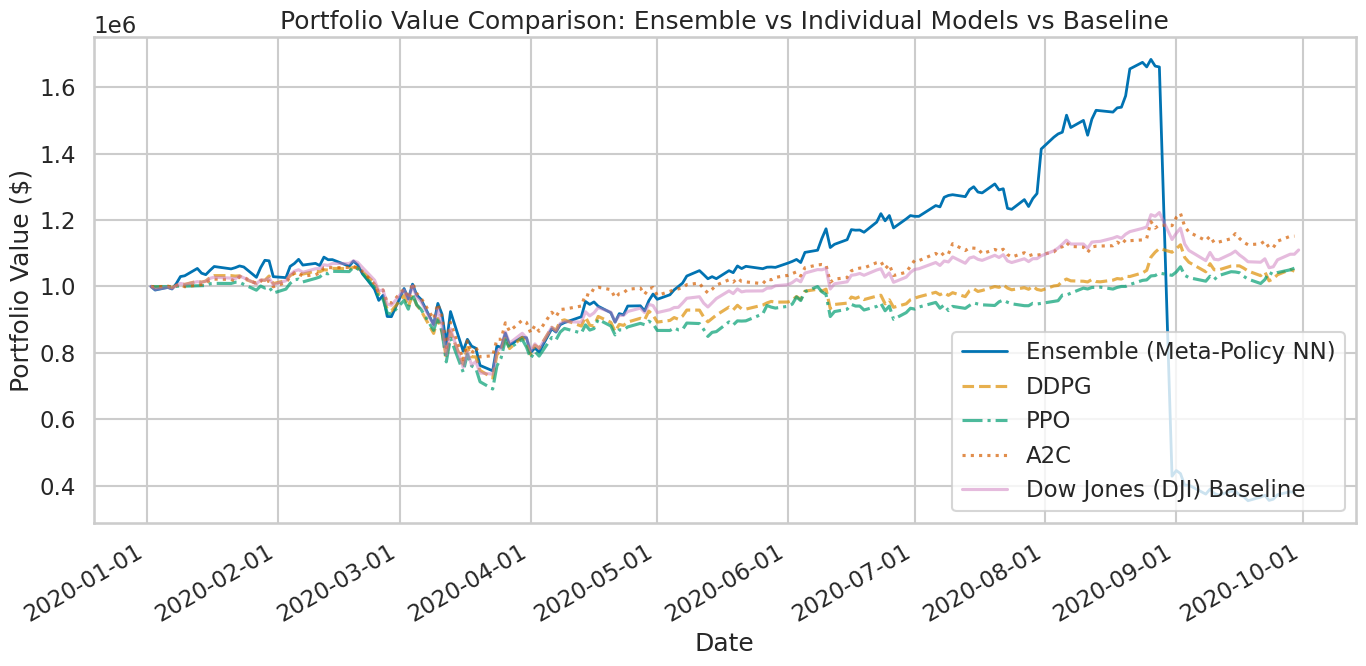

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Set a Seaborn theme for a cleaner look
sns.set_theme(style='whitegrid', context='talk')

# Define a Seaborn color palette
palette = sns.color_palette("colorblind", 5)

# Convert 'date' columns to datetime if they are not already
ensemble_results['date'] = pd.to_datetime(ensemble_results['date'])
ddpg_results['date'] = pd.to_datetime(ddpg_results['date'])
ppo_results['date'] = pd.to_datetime(ppo_results['date'])
a2c_results['date'] = pd.to_datetime(a2c_results['date'])

# Ensure baseline_df is correctly converted and assigned
baseline_df['date'] = pd.to_datetime(baseline_df['date'])  # Fix: Correctly using baseline_df
dji = baseline_df  # Ensure we use the correct DataFrame reference

# Create the figure
plt.figure(figsize=(14, 7))

# Plot each series using Seaborn's palette for consistency
plt.plot(ensemble_results['date'], ensemble_results['account_value'], 
         label='Ensemble (Meta-Policy NN)', linewidth=2, color=palette[0])
plt.plot(ddpg_results['date'], ddpg_results['account_value'], 
         label='DDPG', linestyle='--', alpha=0.7, color=palette[1])
plt.plot(ppo_results['date'], ppo_results['account_value'], 
         label='PPO', linestyle='-.', alpha=0.7, color=palette[2])
plt.plot(a2c_results['date'], a2c_results['account_value'], 
         label='A2C', linestyle=':', alpha=0.7, color=palette[3])
plt.plot(dji['date'], dji['close'], 
         label='Dow Jones (DJI) Baseline', linestyle='-', alpha=0.5, color=palette[4])

# Format the x-axis for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add titles and labels
plt.title('Portfolio Value Comparison: Ensemble vs Individual Models vs Baseline')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


### Training (Third Iteration)